In [1]:
import pdf2image
import os
import glob
import cv2
import numpy as np
import layoutparser as lp
import matplotlib.pyplot as plt
from PIL import Image

### Open pdf

In [2]:
path_pdf = "/resources/datasets/image_recognition/sentencias/FALLO_TOMO CAF 023440_2022_CS001.pdf"

In [3]:
doc = pdf2image.convert_from_path(path_pdf)
len(doc)

22

### Create png by page

In [4]:
OUTPUT_PATH = '/resources/datasets/image_recognition/sentencias/images/'

In [5]:
def create_image_from_pdf(pdf_path: str, OUTPUT_PATH: str):
    image_path = pdf2image.convert_from_path(
        pdf_path,
        dpi=600,
        output_folder=OUTPUT_PATH,
        fmt='png',
        paths_only=True,
        output_file= "image_"
    )[0]

In [ ]:
create_image_from_pdf(path_pdf, OUTPUT_PATH)

### Open images and Images detect

In [6]:
def apply_image_detect(img_array):
    model = lp.Detectron2LayoutModel("lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config",
                                     extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
                                     label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})
    return model.detect(img_array)
    
# def transform_images(folder_images_path: str):
#     """Transforma imagenes de una carpeta en array"""
#     images = [[cv2.imread(file), file] for file in glob.glob(folder_images_path)]
#     imgs_array_info = [[np.asarray(image[0]),image[1]] for image in images]
#     return imgs_array_info

def transform_images(folder_images_path: str):
    """Transforma imagenes de una carpeta en array"""
    images = [[cv2.imread(file), file] for file in glob.glob(folder_images_path)]
    imgs_array_info = [{'image': np.asarray(image[0]), 'path': image[1]} for image in images]
    return imgs_array_info

def classifier(imgs_array_info):
    """Return True si hay figura"""
    layuout = apply_image_detect(imgs_array_info['image'])
    for ly in layuout.get_info('type'):
        if ly =='Figure':
            return True
        else:
            return False

In [7]:
images = transform_images("/resources/datasets/image_recognition/sentencias/images/*.png")

In [8]:
images[0].keys()

dict_keys(['image', 'path'])

In [9]:
len(images)

22

In [10]:
img_fig = [img for img in images if classifier(img)]

/usr/local/lib/python3.8/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.8/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [11]:
len(img_fig)

5

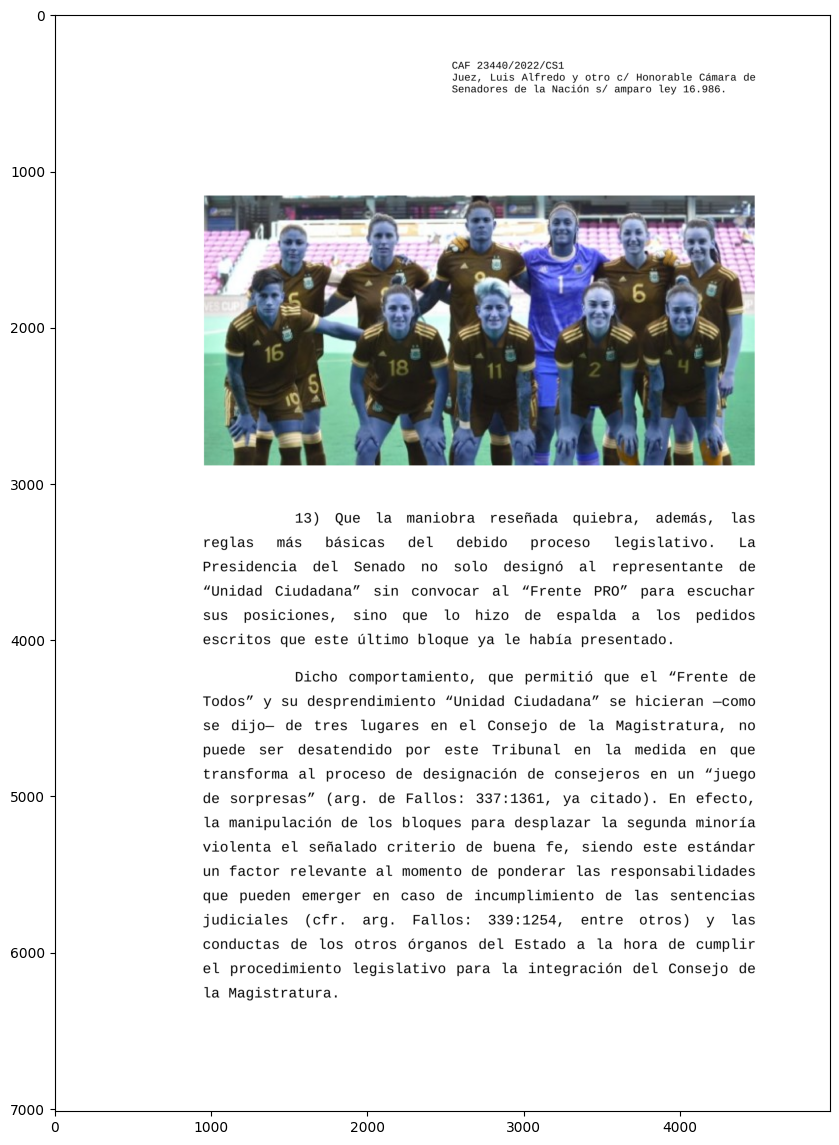

In [12]:
img_test = img_fig[4]
plt.figure(figsize=(10,40))
plt.imshow(img_test['image'])

In [13]:
img_test.keys()

dict_keys(['image', 'path'])

### Analize images

In [14]:
def get_figure_boxes(img_array_info):
    df_lyt = apply_image_detect(img_array_info['image']).to_dataframe()
    df_lyt_fig = df_lyt[df_lyt['type']=='Figure']
    d = df_lyt_fig.to_dict()
    box = {
        'x_1': int(d['x_1'][0]),
        'y_1': int(d['y_1'][0]),
        'x_2': int(d['x_2'][0]),
        'y_2': int(d['y_2'][0])
    }
    img_array_info['box']=box
    return img_array_info

In [15]:
image_test = get_figure_boxes(img_test)
image_test.keys()

dict_keys(['image', 'path', 'box'])

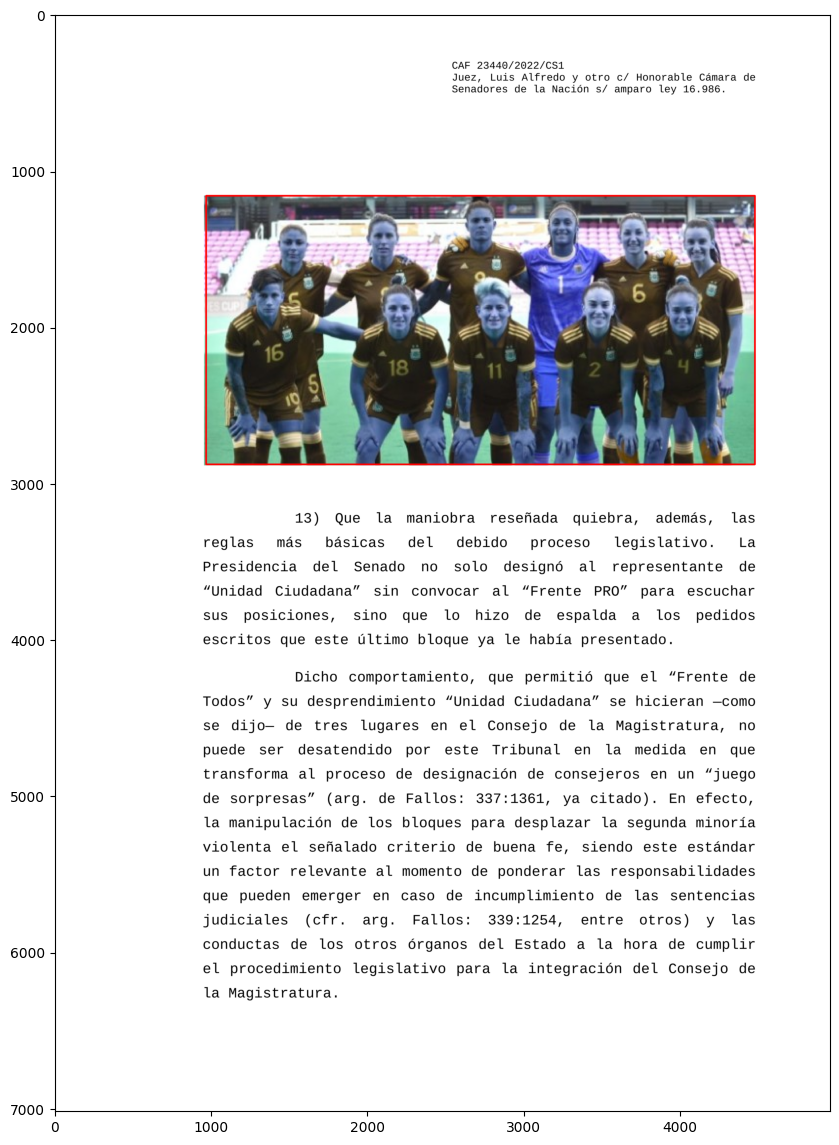

In [16]:
cv2.rectangle(img_test['image'], (image_test['box']['x_1'], image_test['box']['y_1']), (image_test['box']['x_2'], image_test['box']['y_2']), (255, 0, 0), 10)
plt.figure(figsize=(10,40))
plt.imshow(img_test['image'])

### Analize figure in images

In [17]:
def face_recognition(img_info):
    face_cascade = cv2.CascadeClassifier("/resources/datasets/image_recognition/haarcascade_frontalface_default.xml")
    fig = img_info['image'][img_info['box']['y_1']:img_info['box']['y_2'], img_info['box']['x_1']:img_info['box']['x_2']]
    gray = cv2.cvtColor(fig, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 5)
    img_info['box_img']= fig
    img_info['faces_box']= faces
    return img_info

In [18]:
image_test = face_recognition(img_test)

In [19]:
image_test.keys()

dict_keys(['image', 'path', 'box', 'box_img', 'faces_box'])

In [20]:
def blurear_(img_array):
    for (x,y,w,h) in img_array['faces_box']:
        area_color = img_array['box_img'][y:y + h, x:x + w]
        blur = cv2.GaussianBlur(area_color, (1001, 1001), 0)
        img_array['box_img'][y:y + h, x:x + w] = blur
    return img_array

In [24]:
image_test['path']

'/resources/datasets/image_recognition/sentencias/images/image_0001-18.png'

In [25]:
def save_page_image(img_array):
    im = Image.fromarray(img_array['image'])
    im.save(image_test['path'])

/resources/datasets/image_recognition/sentencias/images/image_0001-18.png


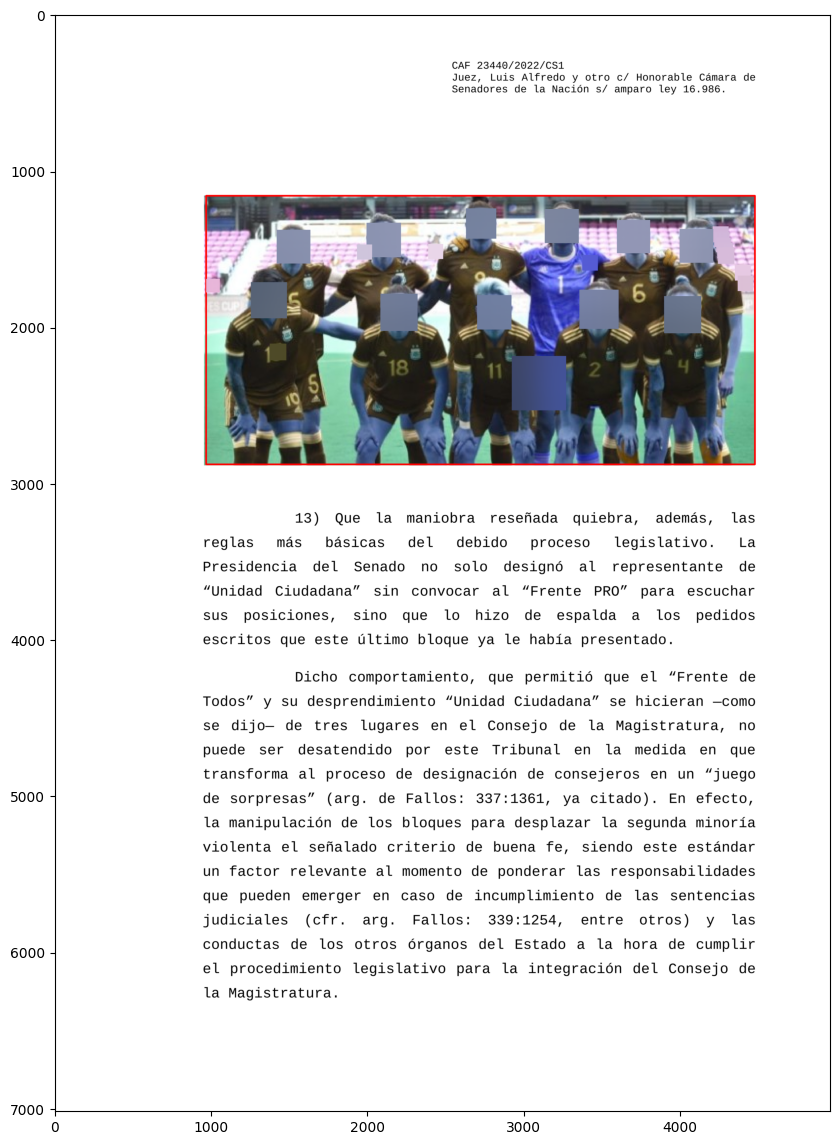

In [22]:
plt.figure(figsize=(10,40))
plt.imshow(image_test['image'])
print(image_test['path'])

In [26]:
save_page_image(image_test)

In [38]:
def convert_to_pdf(img_array):
    im = Image.fromarray(img_array['image'])
    im.save('/resources/datasets/image_recognition/sentencias/images/test.pdf')

In [37]:
convert_to_pdf(image_test)